# KMeans

Based on <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data
from common.paths import HEALTHY, ADHD

X, Y, demographics, population = get_data(label_path=ADHD)
ages = demographics['Age']
sexes = demographics['Sex']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (373, 34716) | Y: 6 | Age: (373,) | Population: adhd


In [3]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## Determine number of clusters

### Silhouette Analysis

In [6]:
%%time

range_n_clusters = [n for n in range(2, 6)]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'Num clusters: {n_clusters} | Avg silhouette score: {silhouette_avg}')

Num clusters: 2 | Avg silhouette score: 0.12292705476284027
Num clusters: 3 | Avg silhouette score: 0.12636087834835052
Num clusters: 4 | Avg silhouette score: 0.06492592394351959
Num clusters: 5 | Avg silhouette score: 0.04043480381369591


### Bayesian Information Criterion

In [4]:
%%time

range_n_clusters = [n for n in range(2, 10)]
bics = []
X_ss = StandardScaler().fit_transform(X)

for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', reg_covar=1e-5)
    gmm.fit(X_ss)
    bic = gmm.bic(X_ss)
    bics.append(bic)
    print(f'Num clusters: {n_clusters} | BIC: {bic:.2f}')

Num clusters: 2 | BIC: 35516822.41
Num clusters: 3 | BIC: 35150040.66
Num clusters: 4 | BIC: 35021203.35
Num clusters: 5 | BIC: 35298709.52
Num clusters: 6 | BIC: 35191580.72
Num clusters: 7 | BIC: 35683352.44
Num clusters: 8 | BIC: 35304733.96
Num clusters: 9 | BIC: 35714231.29
CPU times: user 2min 5s, sys: 7.1 s, total: 2min 12s
Wall time: 13.5 s


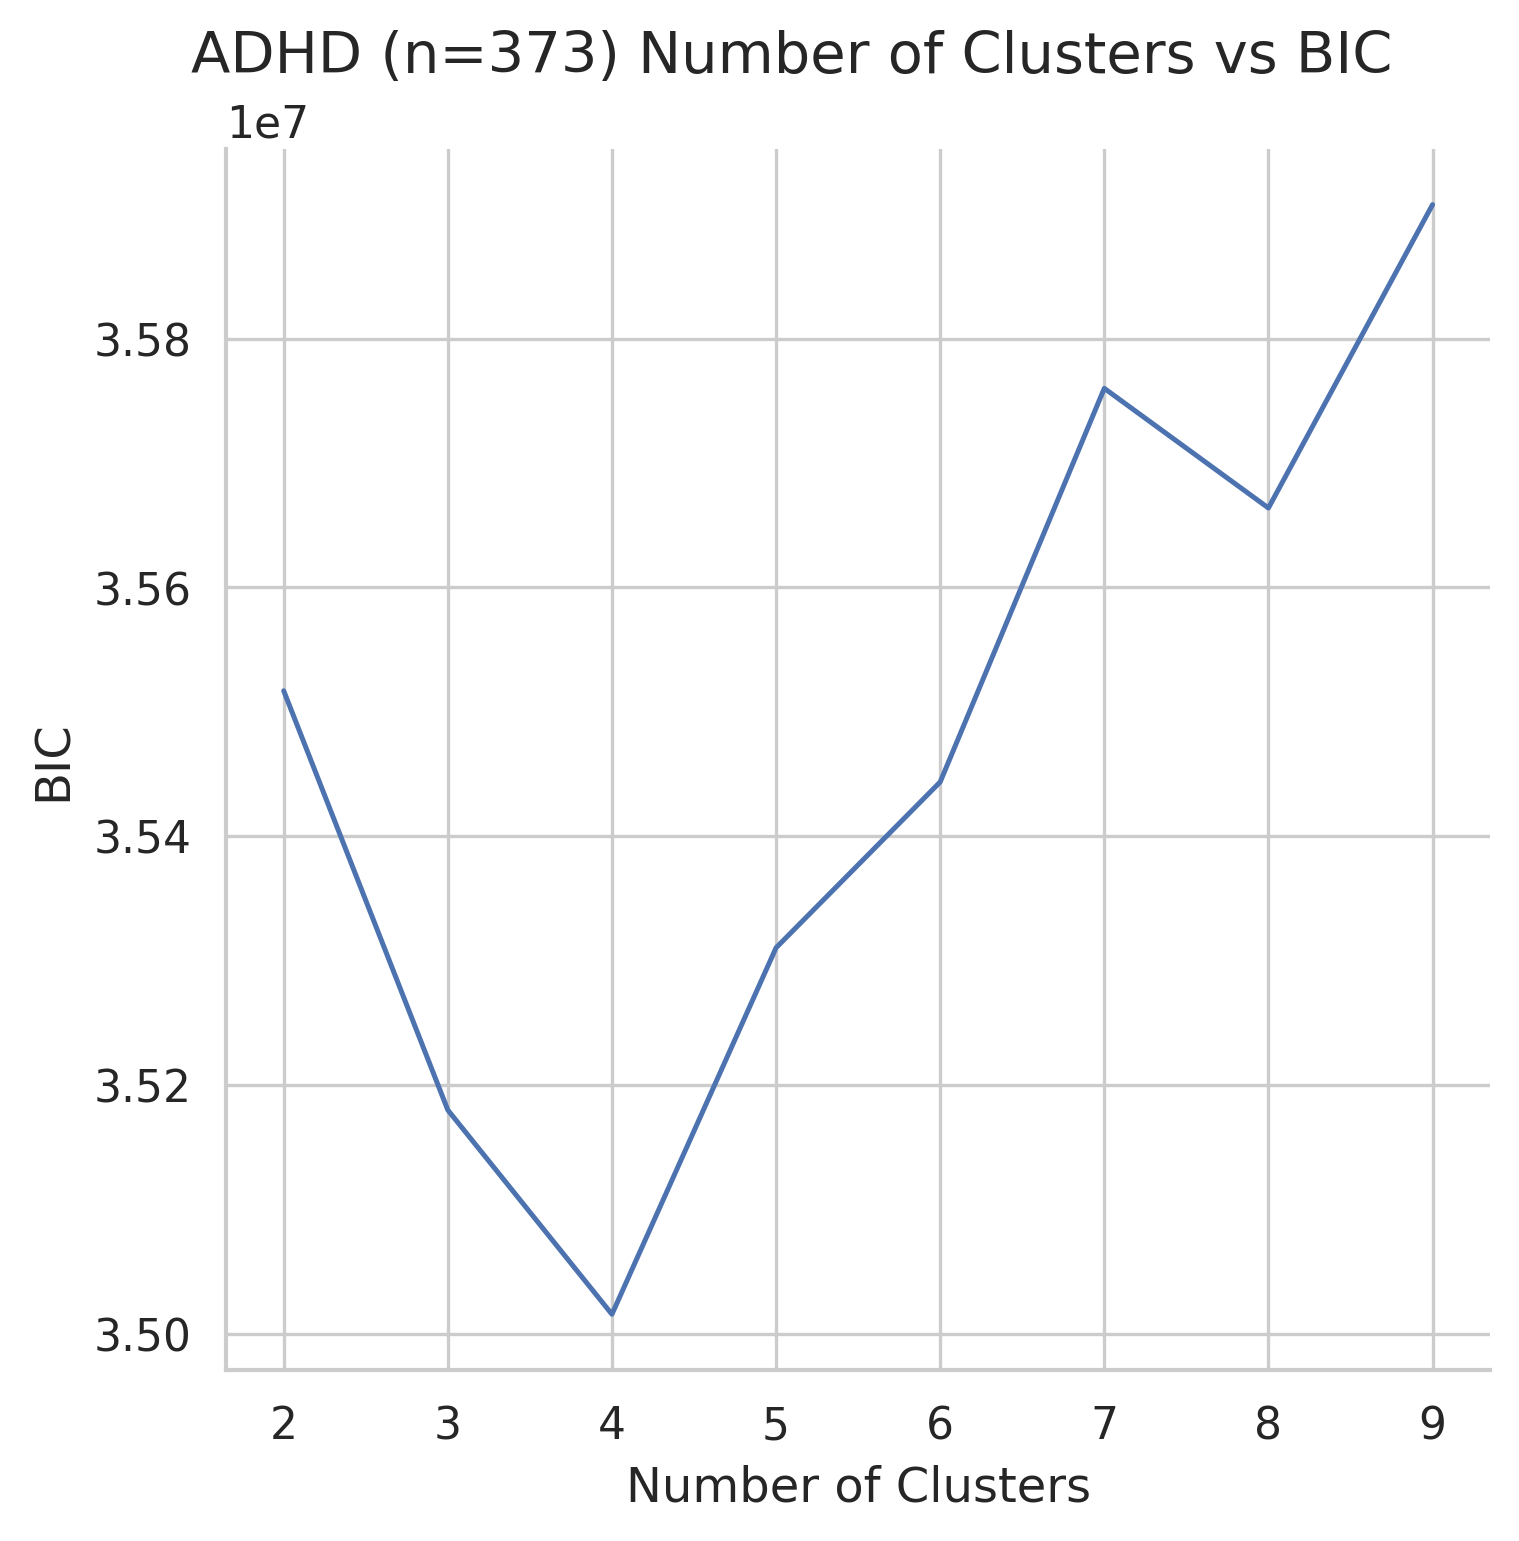

In [12]:
g = sns.relplot(x=range_n_clusters, y=bics, kind="line")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f'ADHD (n={X.shape[0]}) Number of Clusters vs BIC')
g.set_axis_labels('Number of Clusters', 'BIC')

## Run Clustering

In [5]:
clusters = 4
clusterer = KMeans(n_clusters=clusters)
cluster_labels = clusterer.fit_predict(X)

cluster_indices = []
for cluster in range(0, clusters):
    cluster_indices.append(np.where(cluster_labels == cluster))

In [6]:
ages_clusters = [ages[indices] for indices in cluster_indices]
sexes_clusters = [sexes[indices] for indices in cluster_indices]

for cluster, age_cluster in enumerate(ages_clusters):
    print(f"Cluster {cluster} Age: {np.mean(age_cluster):.2f} ({np.std(age_cluster):.2f})")

print("---")
    
for cluster, sex_cluster in enumerate(sexes_clusters):
    label, counts = np.unique(sex_cluster, return_counts=True)
    print(f"Cluster {cluster} Sex: {label, counts}")
#     print(f"Cluster {cluster} Sex: M={counts[0]} F={counts[1]}")

Cluster 0 Age: 11.08 (2.34)
Cluster 1 Age: 9.80 (2.48)
Cluster 2 Age: 11.00 (2.43)
Cluster 3 Age: 10.73 (2.58)
---
Cluster 0 Sex: (array([0, 1]), array([41, 13]))
Cluster 1 Sex: (array([0, 1]), array([88, 28]))
Cluster 2 Sex: (array([0, 1]), array([70, 34]))
Cluster 3 Sex: (array([0, 1]), array([75, 24]))


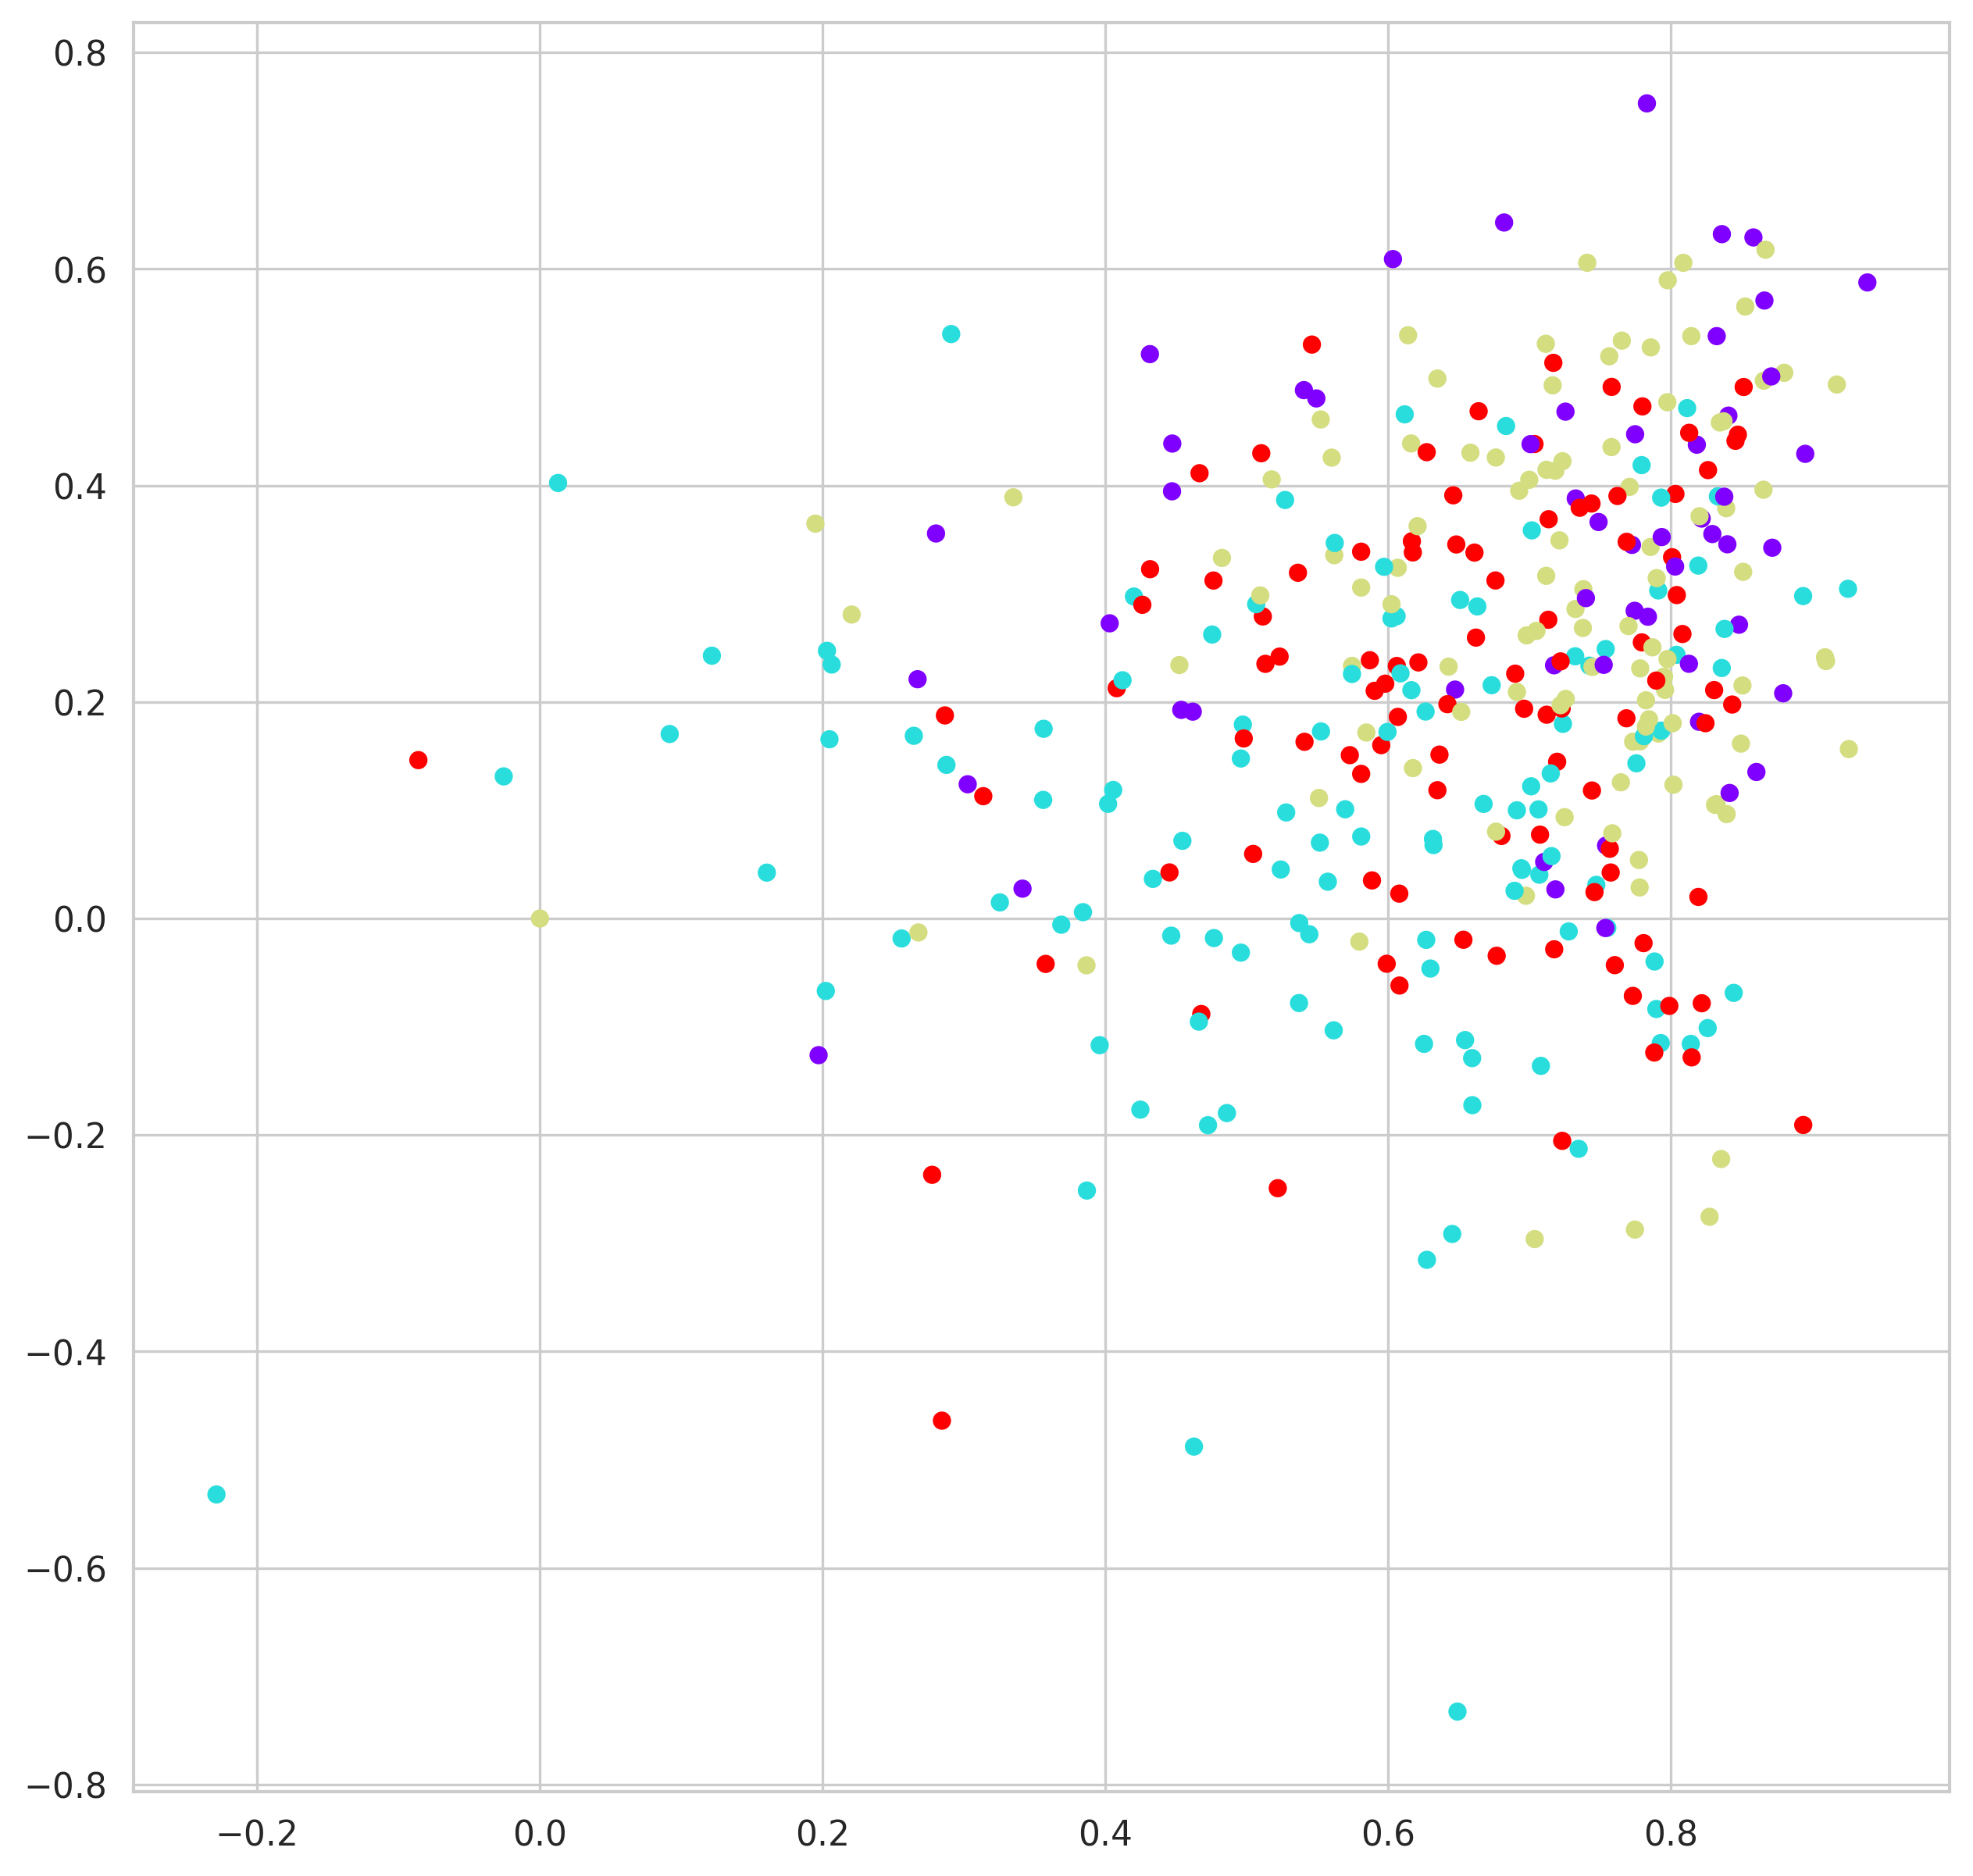

In [7]:
plt.scatter(X[:,0],X[:,1], c=clusterer.labels_, cmap='rainbow')

WISC_FSIQ
Cluster 0 WISC_FSIQ: 96.59 (14.17)
Cluster 1 WISC_FSIQ: 102.39 (16.16)
Cluster 2 WISC_FSIQ: 100.08 (15.77)
Cluster 3 WISC_FSIQ: 99.45 (17.68)
---
WISC_VSI
Cluster 0 WISC_VSI: 100.07 (15.49)
Cluster 1 WISC_VSI: 106.03 (18.07)
Cluster 2 WISC_VSI: 100.50 (15.63)
Cluster 3 WISC_VSI: 101.12 (17.64)
---
WISC_VCI
Cluster 0 WISC_VCI: 101.89 (12.32)
Cluster 1 WISC_VCI: 106.36 (16.64)
Cluster 2 WISC_VCI: 105.85 (15.49)
Cluster 3 WISC_VCI: 104.37 (16.76)
---
WISC_FRI
Cluster 0 WISC_FRI: 100.09 (15.55)
Cluster 1 WISC_FRI: 104.16 (15.41)
Cluster 2 WISC_FRI: 101.19 (15.54)
Cluster 3 WISC_FRI: 98.83 (17.53)
---
WISC_WMI
Cluster 0 WISC_WMI: 96.31 (14.85)
Cluster 1 WISC_WMI: 99.09 (15.18)
Cluster 2 WISC_WMI: 98.99 (13.98)
Cluster 3 WISC_WMI: 98.64 (16.43)
---
WISC_PSI
Cluster 0 WISC_PSI: 90.96 (14.36)
Cluster 1 WISC_PSI: 92.19 (15.39)
Cluster 2 WISC_PSI: 93.92 (15.61)
Cluster 3 WISC_PSI: 96.54 (15.08)
---


Text(0.5, 1.0, 'KMeans: WISC Box Plot per Cluster')

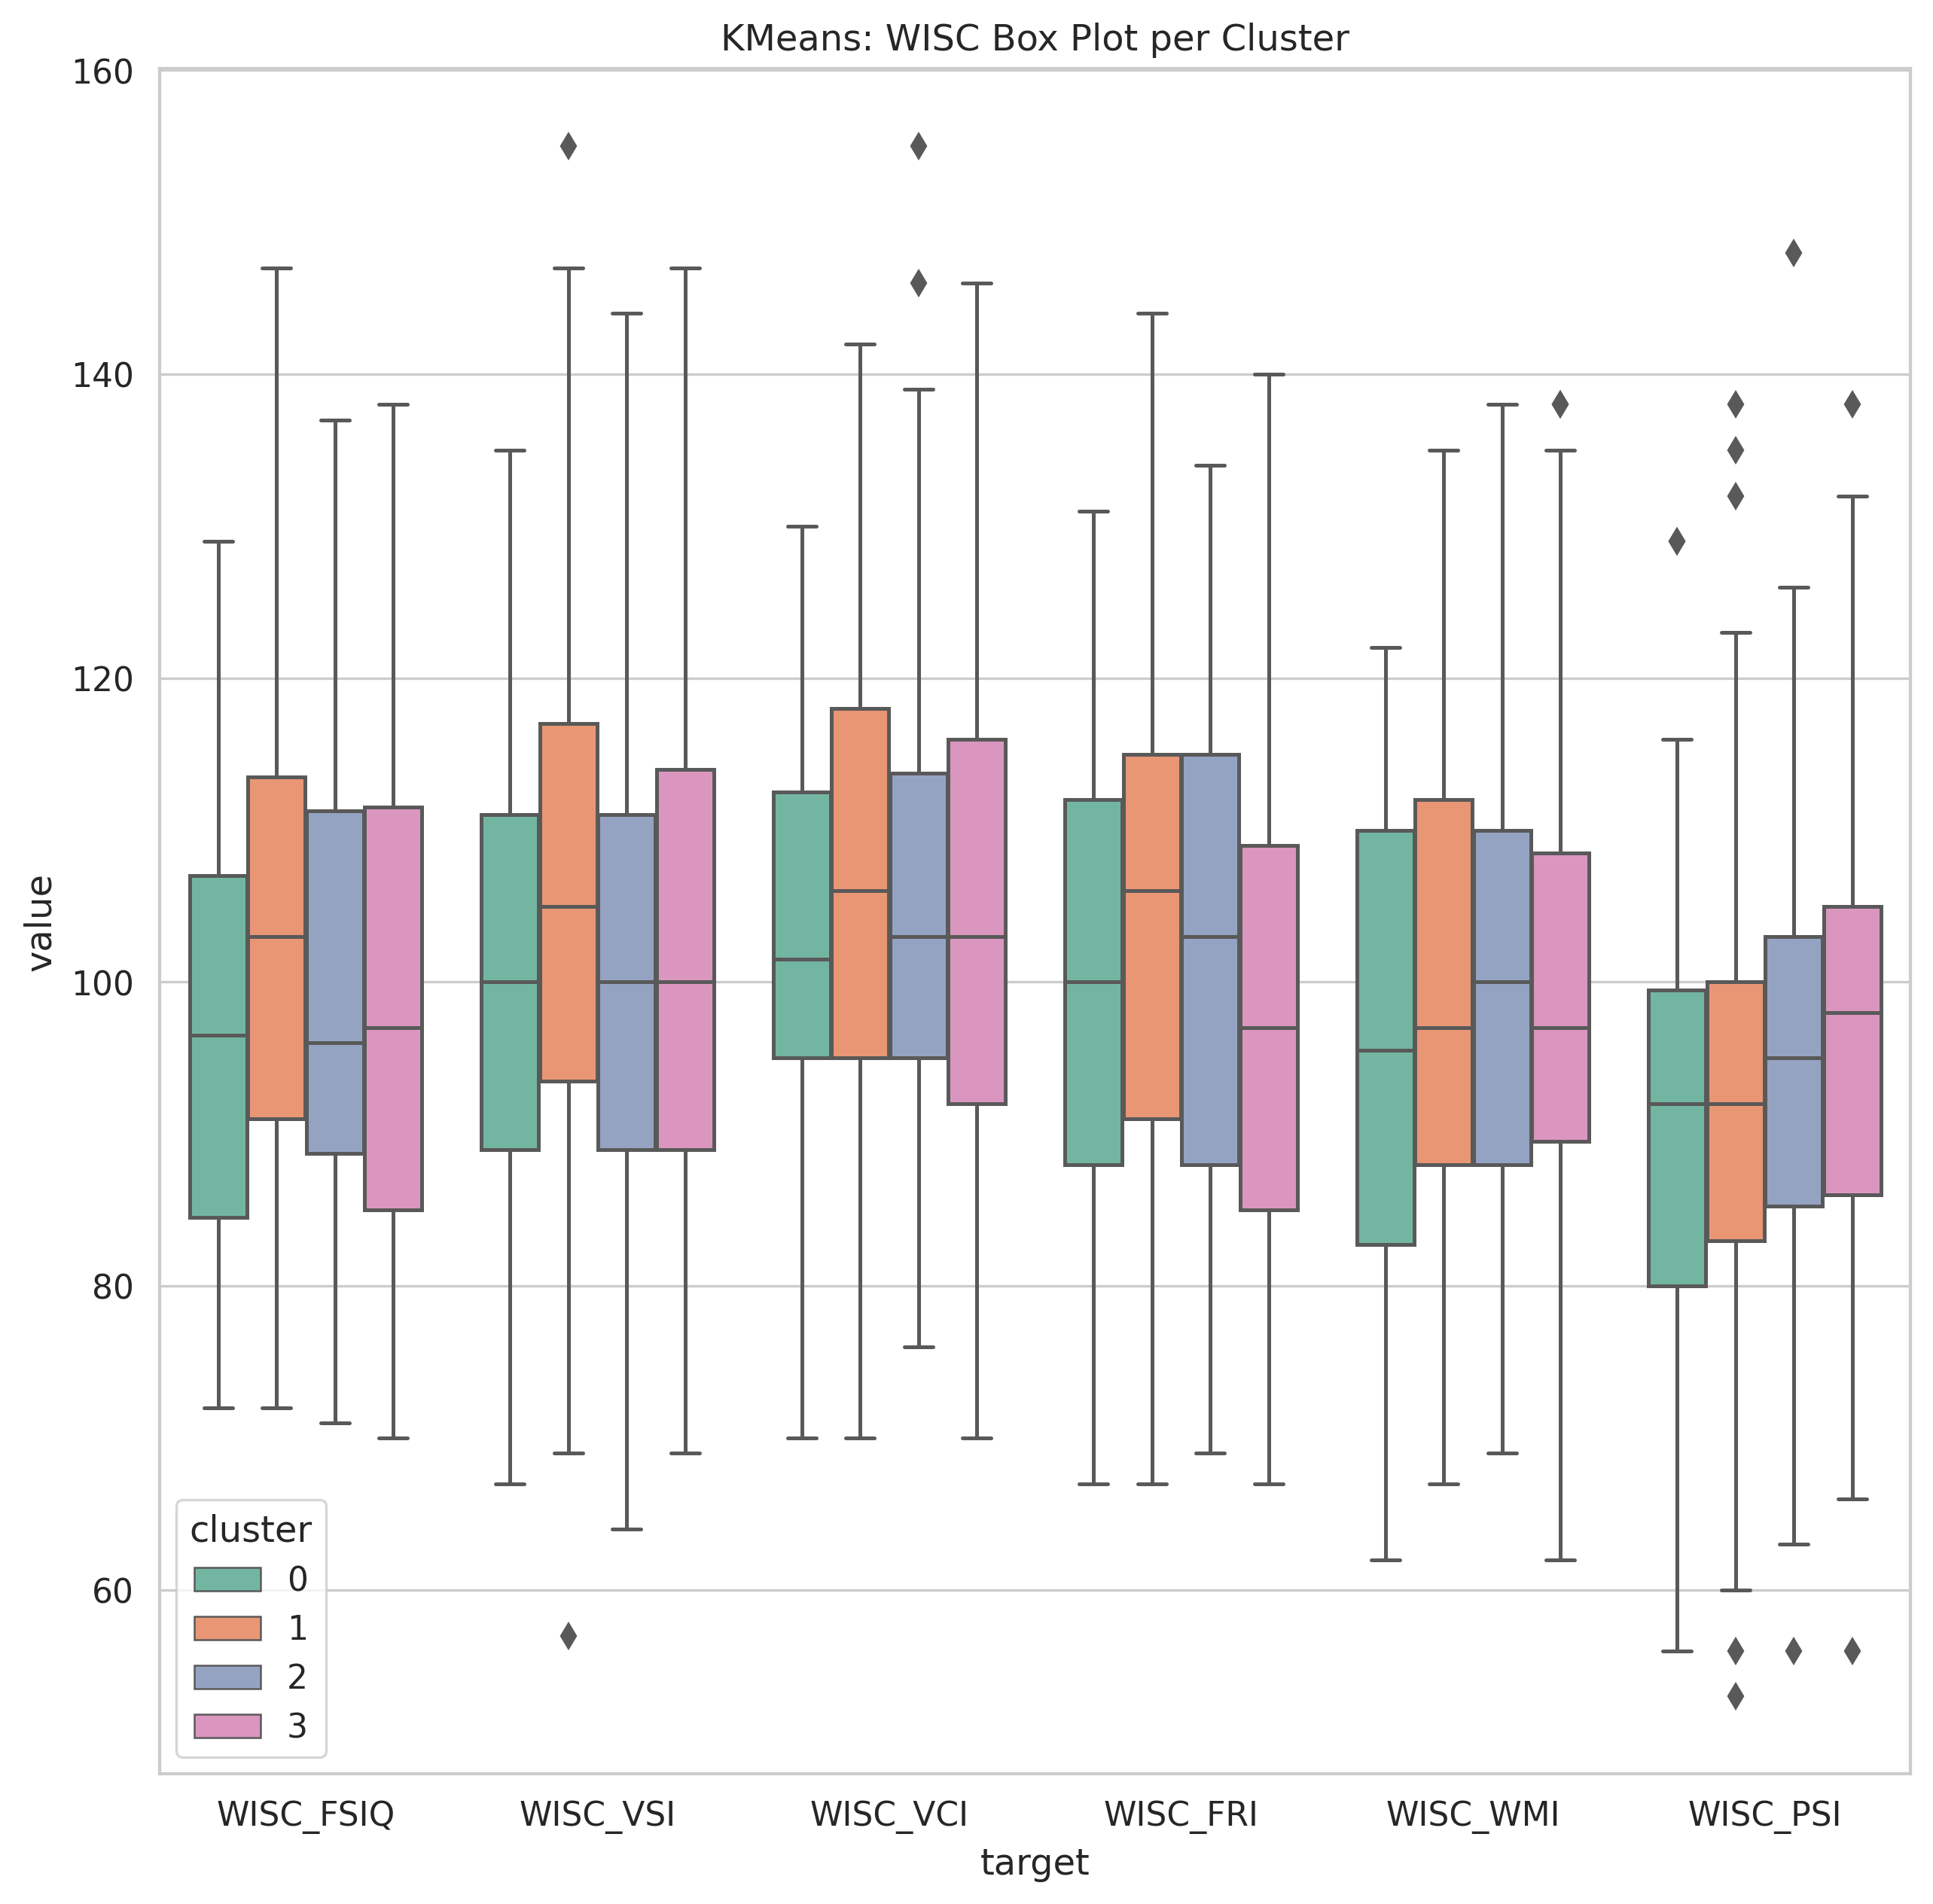

In [8]:
from common.wisc import WISC_LEVEL

data = []

for target in WISC_LEVEL[5]:
    y = Y[target]
    y_clusters = [y[indices] for indices in cluster_indices]
    
    print(target)
    for cluster, y_cluster in enumerate(y_clusters):
        print(f"Cluster {cluster} {target}: {np.mean(y_cluster):.2f} ({np.std(y_cluster):.2f})")
        data += [(cluster, target, value) for value in y_cluster]
    print("---")

#     data += [(1, target, value) for value in y_cluster_one]
#     data += [(2, target, value) for value in y_cluster_two]

data = pd.DataFrame(data, columns=['cluster', 'target', 'value'])
# display(data)
# g = sns.FacetGrid(data, col="cluster", row="target")
# g.map_dataframe(sns.boxplot, x='value', orient='v')

ax = sns.boxplot(x='target', y='value', hue='cluster', data=data, palette="Set2", 
                 order=WISC_LEVEL[5], orient='v')
ax.set_title('KMeans: WISC Box Plot per Cluster')

In [25]:
from os.path import join
from common.paths import SCRATCH_DATA


def pad_dict_list(dict_list, padel):
    dict_list_padded = dict_list.copy()
    list_max = np.max([len(l) for l in dict_list.values()])
    
    for k, v in dict_list.items():
        list_len = len(v)
        
        if list_len < list_max:
            dict_list_padded[k] = np.concatenate(
                (dict_list_padded[k], np.full(list_max - list_len, padel)))
    
    return dict_list_padded


csv_data = {}

for target in WISC_LEVEL[5]:
    y = Y[target]
    
    for cluster_num, indices in enumerate(cluster_indices):
        csv_data[f'{target}_cluster_{cluster_num}'] = y[indices]

csv_data = pad_dict_list(csv_data, -1)
csv_data = pd.DataFrame(csv_data)
display(csv_data)
filename = 'kmeans_wisc_per_cluster.csv'
csv_data.to_csv(join(SCRATCH_DATA, filename))

,WISC_FSIQ_cluster_0,WISC_FSIQ_cluster_1,WISC_FSIQ_cluster_2,WISC_FSIQ_cluster_3,WISC_VSI_cluster_0,WISC_VSI_cluster_1,WISC_VSI_cluster_2,WISC_VSI_cluster_3,WISC_VCI_cluster_0,WISC_VCI_cluster_1,...,WISC_FRI_cluster_2,WISC_FRI_cluster_3,WISC_WMI_cluster_0,WISC_WMI_cluster_1,WISC_WMI_cluster_2,WISC_WMI_cluster_3,WISC_PSI_cluster_0,WISC_PSI_cluster_1,WISC_PSI_cluster_2,WISC_PSI_cluster_3
0,92,115,120,91,86,102,114,94,108,113,...,103,97,82,117,103,79,100,108,116,100
1,89,97,128,99,86,100,111,108,89,95,...,123,103,97,103,125,107,92,95,119,92
2,75,95,82,126,78,97,81,114,81,106,...,97,121,79,74,79,132,72,103,63,119
3,107,74,86,96,122,86,97,97,108,70,...,91,97,110,88,88,107,77,53,95,83
4,102,97,72,88,108,111,72,94,106,118,...,76,76,79,82,76,65,105,75,98,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,-1,73,-1,-1,-1,86,-1,-1,-1,76,...,-1,-1,-1,76,-1,-1,-1,69,-1,-1
112,-1,87,-1,-1,-1,86,-1,-1,-1,95,...,-1,-1,-1,91,-1,-1,-1,77,-1,-1
113,-1,115,-1,-1,-1,119,-1,-1,-1,142,...,-1,-1,-1,103,-1,-1,-1,72,-1,-1
114,-1,113,-1,-1,-1,144,-1,-1,-1,113,...,-1,-1,-1,100,-1,-1,-1,95,-1,-1
